In [1]:
import os
import time
import torch
import torch.nn as nn
from typing import Literal

import wandb
from dataset import CLIPDataset, get_transforms, collate_fn
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer
from utils.common import get_device
from tqdm import tqdm
from clip import CLIPModel, clip_loss  # type: ignore
from train import build_loader, wandb_config

config = wandb_config['config']
device = config['device']


def get_image_embeddings(mode: Literal['train', 'test'], model_path):
    tokenizer: DistilBertTokenizer = DistilBertTokenizer.from_pretrained(
        config['text_encoder']['model_name'])
    loader = build_loader(mode, config, tokenizer)

    model = CLIPModel(
        text_model_name=config['text_encoder']['model_name'],
        image_model_name=config['image_encoder']['model_name'],
        text_pretrained=config['text_encoder']['pretrained'],
        text_trainable=config['text_encoder']['trainable'],
        image_pretrained=config['image_encoder']['pretrained'],
        image_trainable=config['image_encoder']['trainable'],
        text_embedding_dim=config['text_encoder']['embedding_dim'],
        image_embedding_dim=config['image_encoder']['embedding_dim'],
        projection_dim=config['projection_head']['embedding_dim'],
        temperature=config['train']['temperature']
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(loader):
            image = batch['image'].to(device)
            image_embeddings.append(model.get_image_features(image))
    return model, torch.cat(image_embeddings)

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model, image_embeddings = get_image_embeddings(
    'test', "./models/best_model.pth")

/tmp/ipykernel_44313/2579421079.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
100%|██████████| 127/

In [9]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2


def find_matches(model, image_embeddings, query, image_filenames, n=9, step=1):
    tokenizer: DistilBertTokenizer = DistilBertTokenizer.from_pretrained(
        config['text_encoder']['model_name'])
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_embeddings = model.get_text_features(
            batch['input_ids'], batch['attention_mask']
        )

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * step)
    matches = [image_filenames[idx] for idx in indices[::step]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{config['data']['image_dir']}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

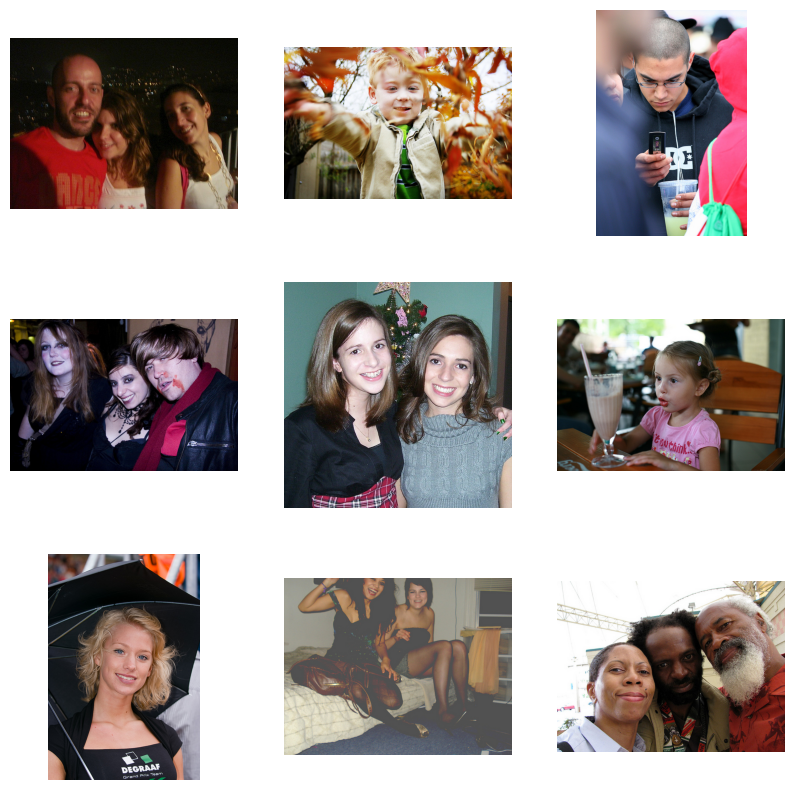

In [13]:
import pandas as pd
image_filenames = pd.read_csv(config['data']['test_data_path'])['image'].values

find_matches(model,
             image_embeddings,
             query="cute lady",
             image_filenames=image_filenames,
             n=9,
             step=2)